In [ ]:
%%capture
!git clone https://github.com/matiasdperez/MEC_tesis.git

In [ ]:
import os
os.chdir('MEC_tesis/')

# Bitcoin

En esta sección, la cual funciona de aplicación práctica, se aplica la misma metodología que los experimentos anteriores pero esta vez sobre el precio de cierre del par BTC-USD. Para ello se extraen 1000 observaciones directamente del sitio de Yahoo Finance! con fecha de inicio del período de análisis 2021-08-05 hasta 2024-04-30.

Se asume que la serie de precios (en realidad, su primera diferencia) sigue un GRW sobre 3 regímenes ocultos, siguiendo a Figá-Talamanca et. al. (2021).

-------
_______

In [ ]:
%load_ext autoreload
%autoreload 2

## 1) Setup

In [ ]:
%%capture
! pip install dieboldmariano pmdarima keras-tuner tensorflow-addons yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import warnings
import tqdm as tqdm
import random
from sklearn.preprocessing import StandardScaler
from dieboldmariano import dm_test

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

np.random.seed(42)

import yfinance as yf
from utils.statistical_models import *
from utils.NN_models import *

## 2) Data Retrieval

TO Do

In [ ]:
btc = yf.Ticker("BTC-USD")
hist = btc.history(period="max")

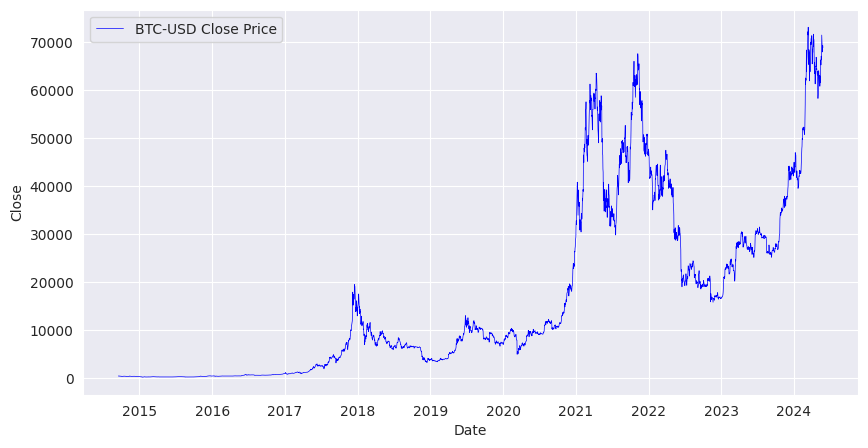

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(hist.Close, lw = 0.5, color = 'blue', label='BTC-USD Close Price');

Se toma una muestra de 1000 observaciones de la serie de tiempo de los precios de cierre de Bitcoin, con fecha de finalización el 2024-04-30

In [ ]:
sample = hist.loc[hist.index <= pd.to_datetime('2024-04-30').tz_localize('UTC'), 'Close'].tail(1000)

De las 1,000 observaciones extraidas, las primeras 750 constituyen el dataset de entrenamiento y las segundas 250, el de test. Se complementa este análisis con la serie de primeras diferencias y la estimación del estado oculto. Este se construye partiendo de la propuesta de Figá-Talamanca et. at. (2021) de modelar la primera diferencia del par BTC-USD como un *Generalized Random Walk* con 3 estados ocultos (baja volatilidad, alta volatilidad con retornos positivos y baja volatilidad con retornos negativos) y estimando un Markov-switching model con la implementación de Statmodels. Una vez estimado el modelo, se calculan las probabilidades filtradas de que el sistema se encuentre en un momento del tiempo en un estado dado.

In [ ]:
first_diff = sample.diff().dropna()

In [ ]:
mod_hamilton = sm.tsa.MarkovAutoregression(
    first_diff,
    k_regimes=3,
    trend='n',
    exog_tvtp = np.ones_like(first_diff),
    order = 1,
    switching_trend=False,
    switching_exog = True,
    switching_variance=True
)
res_hamilton = mod_hamilton.fit(maxiter=1000)

hidden_state = [np.argmax(i) for i in res_hamilton.smoothed_marginal_probabilities.values.reshape(-1,3)]

La serie `hidden_state` contiene el estado oculto predicho para cada timestep y es calculado como la moda de la distribución de los estados para este timestep.



In [ ]:
print(res_hamilton.summary())

                         Markov Switching Model Results                         
Dep. Variable:                    Close   No. Observations:                  998
Model:             MarkovAutoregression   Log Likelihood               -8225.344
Date:                  Sun, 26 May 2024   AIC                          16474.689
Time:                          23:52:05   BIC                          16533.558
Sample:                      08-06-2021   HQIC                         16497.065
                           - 04-30-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.42e+05   1.91e+04      7.435      0.000    1.05e+05    1.79e+05
ar.L1         -0.1131      0.049    

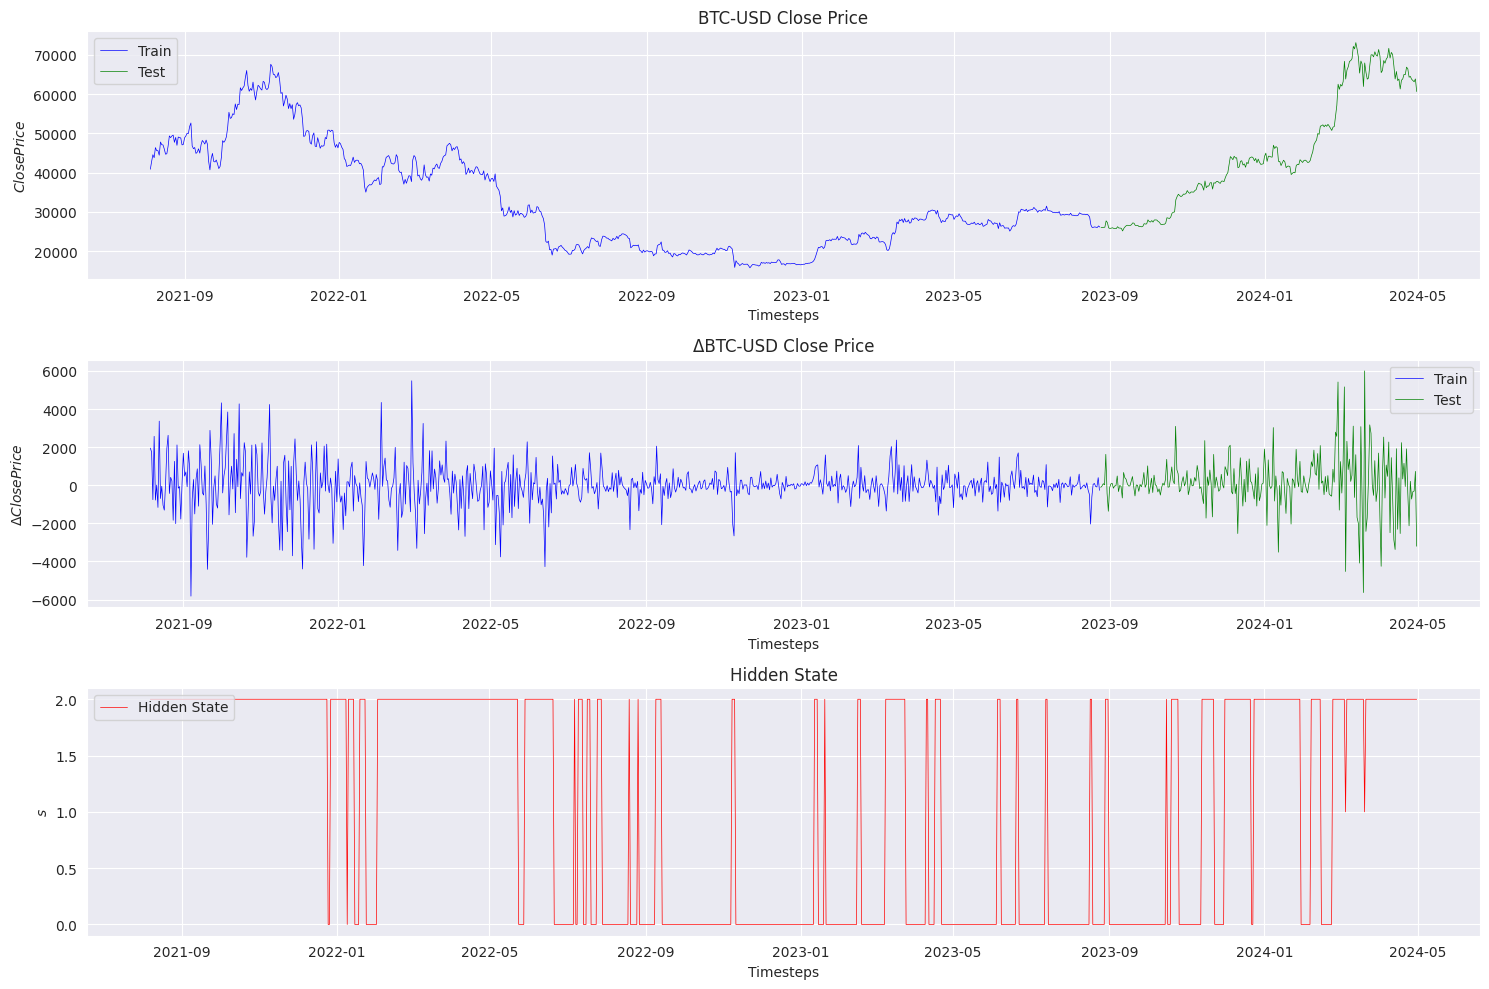

In [ ]:
split_index = int(len(sample) * 0.75)

fig, axs = plt.subplots(3,1,figsize=(15, 10))

sns.lineplot(x=sample.index[:split_index], y=sample[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=sample.index[split_index:], y=sample[split_index:], ax=axs[0], lw=0.5, color='green', label='Test')
axs[0].set_title("BTC-USD Close Price")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$Close Price$")

sns.lineplot(x=first_diff.index[:split_index-1], y=first_diff[:split_index-1], ax=axs[1], lw=0.5, color='blue', label='Train')
sns.lineplot(x=first_diff.index[split_index-1:], y=first_diff[split_index-1:], ax=axs[1], lw=0.5, color='green', label='Test')
axs[1].set_title("ΔBTC-USD Close Price")
axs[1].set_xlabel("Timesteps")
axs[1].set_ylabel("$Δ Close Price$")

sns.lineplot(x=first_diff.index[1:], y=hidden_state, ax=axs[2], lw=0.5, color='red', label='Hidden State')
axs[2].set_title("Hidden State")
axs[2].set_xlabel("Timesteps")
axs[2].set_ylabel("$s$")

plt.legend(loc='upper left')
plt.tight_layout();


A continuación se presentan las funciones de autocorrelación y autocorrelación parcial para la serie de precios de cierre de Bitcoin.

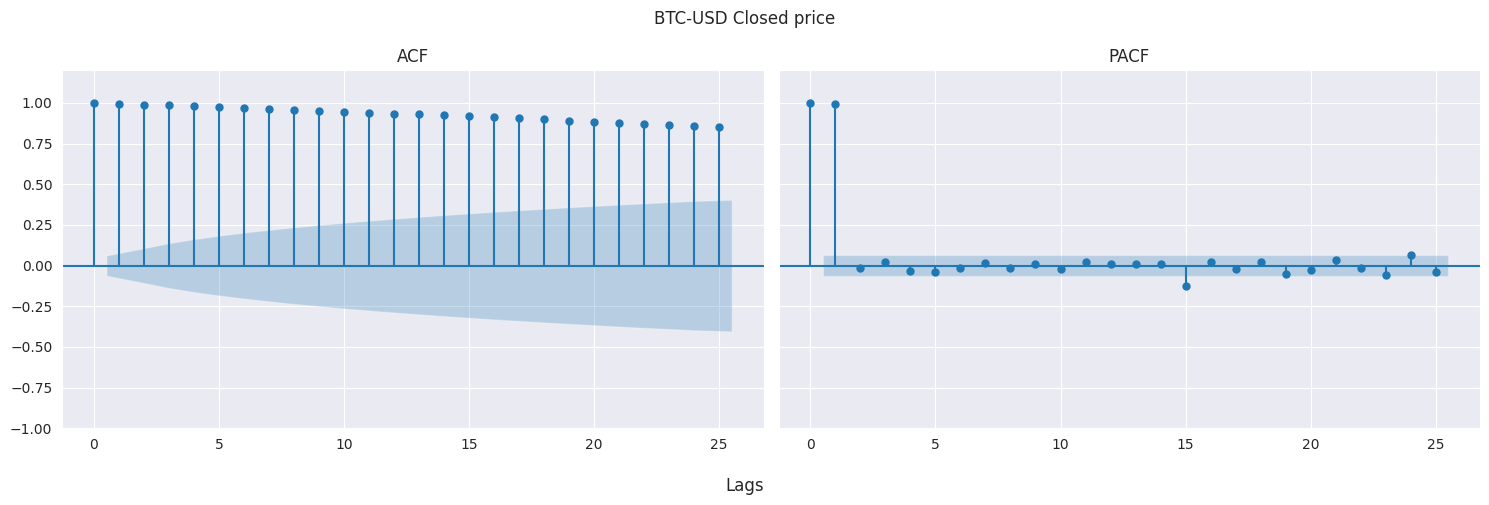

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

plot_acf(sample, lags=25, ax=axs[0])
plot_pacf(sample, lags=25, ax=axs[1])
axs[0].set_title("ACF")
axs[0].set_ylim([-1, 1.2])
axs[1].set_title("PACF")

fig.suptitle("BTC-USD Closed price")
fig.supxlabel('Lags')
plt.tight_layout()
plt.show()

A continuación se realiza el split en train-test. Se toman el primer 75% de las observaciones para train (750 observaciones) y el restante 25% para test (250 observaciones).

In [ ]:
y_train, y_test = sample[:split_index], sample[split_index:]

## 3) Cross-validation de hiperparámetros

En esta fase del workflow de trabajo, se utiliza el conjunto de entrenamiento y validación para buscar el set de hiperparámetros que mejor ajusta la forma funcional del modelo al problema concreto (i.e, aquel modelo que minimiza el error cuadrático medio sobre el conjunto de validación). Los espacios de hiperparámetros definidos para cada modelo son los siguientes:

1) <ins> Modelo ARIMA </ins>: se buscarán de manera automática la tupla (p,I,q), esto es, el orden del término autorregresivo AR, el orden de integración y el órden del término de medias móviles MA dentro de un espacio de hiperparámetros dado por el producto cartesiano especificado por el usuario. Por ejemplo: {0,1,2,3}x{0,1,2}x{0,1,2,3}.
A su vez, para el caso del modelo ARIMA, se utilizan 2 estrategias de cross-validation:

    * Rolling window
    * Sliding window

2) <ins> Modelo ETS </ins>: en el caso del modelo ETS, se buscarán de manera automática sobre un espacio de hiperparámetros que definen la forma funcional de las ecuaciones que rigen el modelo. El mismo se define como el producto cartesiano de los siguientes conjuntos:

    * error_type = {aditivo, multiplicativo}
    * trend_type = {sin_tendencia, aditiva, multiplicativa}
    * dampend_trend = {Verdado, Falso}
    * seasonal_component = {}

    Al igual que para el caso del modelo ARIMA, se utilizan las dos mismas estrategias de cross-validation.

3) <ins> Stacked LSTM </ins>: para el caso de las redes neuronales, se define una arquitectura general dado por el tipo de unidades o neuronas (en este caso, vanilla LSTM) y un espacio de hiperprámetros "grande", el cual no es explorado de manera exhaustiva sino que se escogen una serie de configuraciones de manera aleatoria y se recupera aquella configuración que minimiza la función de pérdida sobre el conjunto de validación (partición del conjunto de entrenamiento original). Una vez más, el espacio de hiperparámetros se construye como el cartesiano de los siguientes conjuntos:

    * Función de activación = {'relu', 'tanh', 'sigmoid', 'elu'} --> función de activación aplicadas a la cell state y al estado oculto de la red.
    * Unidades en la primera capa recurrente = {16, 32, 64, 128}
    * Incluir segunda capa LSTM = {True, False}
    * Unidades en la segunda capa recurrente (en caso de existir) = {16, 32, 64, 128}
    * Unidades en la capa densa = {16, 32, 64, 128} --> número de neuronas en la capa densa que transforma la salida vectorial de la red LSTM en el valor escalar a predecir.
    * Learning Rate = {1e-2, 1e-3, 1e-4} --> learning_rate utilizado por el optimizador en la búsqueda de los parámetros del modelo.
    * Optimizador = {'adam', 'sgd', 'rmsprop'}
    * Dropout rate = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> tasa de dropout, utilizada para eliminar conexiones entre neuronas de manera aleatoria durante la fase de entrenamientod de la red y así evitar overfitting
    * Inicializadores = {'random_normal','glorot_uniform', 'he_normal'} --> distribuciones de las que se samplean los valores iniciales de los pesos y biases de la red, y le da naturaleza estocástica al entrenamiento de la NN.
    * Coeficiente L2 = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> penalización utilizada para evitar que los pesos de la red "crezcan" demasiado y overfitteen la red (aka. weight decay).

4) <ins> LSTM con Peepholes </ins>: mismo espacio de búsqueda de hiperparámetros que el modelo *Stacked LSTM*

5) <ins> Encoder-Decoder LSTM </ins>: la única diferencia en el espacio de hiperparámetros frente a las otras arquitecturas es que en este modelo, en caso de existir una segunda capa oculta, se la fuerza a que tenga una dimensión menor al número de unidades de la primera capa oculta para lograr así la forma de "embudo" típico de las redes neuronales encoder-decoder.


### 3.1) ARIMA model

In [ ]:
# Definición del espacio de hiperparámetros sobre el cual buscar la mejor configuración del modelo para el problema

AR_order = [0,1,2,3]
MA_order = [0,1,2,3]
I_order = [0,1,2]

# Dado que el espacio de búsqueda de hiperparámetros tiene una cardinalidad muy alta para realizar una búsqueda exhaustiva, se opta en su lugar
# por tomar una muestra de 30 combinaciones de hiperparámetros del espacio de búsqueda.

random.seed(1234)
search_space = random.sample(list(product(AR_order, I_order, MA_order)), 30)

A modo de ejemplo, se procede a cross-validar el modelo con el search_space recien construido y bajo las siguientes especificaciones:
* `h = 1`
* `stride = 25`
* `window_length = 50`
* `evaluation_metric = mean_squared_error`

El número de folds se determina de manera automática en base a la combinación de `h`, `stride` y `window_length`.

In [ ]:
arima_vanilla = ArimaModel(y_train, y_test, **{'with_intercept':False, 'method':'nm'})

In [ ]:
arima_vanilla.cross_validate(ARIMA_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 30/30 [03:29<00:00,  6.99s/it]


A continuación se muestra el top 10 configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [ ]:
arima_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,AR_order,I_order,MA_order,rolling_median_MSE,sliding_median_MSE
11,3,1,3,194733.139637,166977.244972
15,2,1,1,195428.009618,169998.021325
27,1,1,1,198555.093415,172938.126883
7,0,1,2,195751.861873,175712.052863
1,0,1,3,202112.879231,179833.170554
0,2,1,0,193268.044075,182827.971992
3,0,1,1,201155.324225,190787.649657
22,1,1,0,199835.721654,193713.413537
17,3,1,2,213605.166910,206364.854682
8,1,2,2,192352.609658,215956.302104


In [ ]:
print(f"La mejor configuración para la estrategia de sliding window es: {arima_vanilla.best_model('sliding')}")

La mejor configuración para la estrategia de sliding window es: (3, 1, 3)


Se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [ ]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

In [ ]:
arima_results = defaultdict(defaultdict)
btc_best_models = defaultdict((lambda: defaultdict(dict))) #En este diccionario se guardará el mejor modelo para cada DGP y combinación de h, stride y window_length

In [ ]:
%%time
for h in h_list:
    best_MSE = np.inf
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(y_train.values, y_test.values, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                       h = h,
                                                       stride=s,
                                                       window_length=l,
                                                       eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            btc_best_models['btc'][h]['arima'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:56<00:00,  5.87s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:58<00:00,  5.94s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [03:06<00:00,  6.20s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:51<00:00,  5.70s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [03:00<00:00,  6.03s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [03:03<00:00,  6.13s/it]

CPU times: user 16min 31s, sys: 13min 5s, total: 29min 36s
Wall time: 17min 56s


Interpretacion TO DO

In [ ]:
arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,0,1,3,1.601651e+05
1,1,25,50,3,1,3,1.669772e+05
2,1,25,100,2,1,2,1.239615e+05
3,7,25,25,3,1,3,1.463881e+06
4,7,25,50,3,1,1,1.508719e+06
5,7,25,100,3,1,2,1.294809e+06


### 3.2) ETS Model

In [ ]:
# Definición del espacio de búsqueda de hiperparámetros para el modelo ETS

config = {
    'error' : ['add','mul'],
    'trend' : ['add','mul', None],
    'damped_trend' : [True, False],
    'seasonal' : [None]
}

# Dado que el espacio de búsqueda tiene baja cardinalidad, a diferencia del modelo ARIMA, se opta por una búsqueda exhaustiva de hiperparámetros

search_space = [dict(zip(config.keys(), x)) for x in product(*config.values())]

In [ ]:
ets_vanilla = EtsModel(y_train, y_test)

In [ ]:
ets_vanilla.cross_validate(ETS_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


A continuación se muestra el top configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [ ]:
ets_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,index,rolling_median_MSE,sliding_median_MSE
8,"{'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}",199087.86823,158503.73129
7,"{'error': 'mul', 'trend': 'mul', 'damped_trend': True, 'seasonal': None}",202625.71719,171523.54961
9,"{'error': 'mul', 'trend': None, 'damped_trend': False, 'seasonal': None}",202659.05525,183233.93883
2,"{'error': 'add', 'trend': 'mul', 'damped_trend': True, 'seasonal': None}",201432.57385,194606.73321
4,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",201431.18247,195372.93888
0,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",201360.98930,201785.98443
5,"{'error': 'mul', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",202439.97026,205571.78011
1,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",149469.50016,211369.95406
3,"{'error': 'add', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}",197316.83762,220696.02884
6,"{'error': 'mul', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",161673.71172,251586.20108


In [ ]:
print(f"La mejor configuración para la estrategia de sliding window es: {ets_vanilla.best_model('sliding')['index']}")

La mejor configuración para la estrategia de sliding window es: {'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}


A continuación, se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [ ]:
h_list = [1,7]
strides_list = [25]
window_length_list = [25, 50, 100]

In [ ]:
ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = np.inf
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(y_train.values, y_test.values)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            btc_best_models['btc'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


In [ ]:
data = []

for key1, value1 in ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
ets_cv = pd.DataFrame(data, columns=columns)

ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",225640.10442
1,1,25,50,"{'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}",158503.73129
2,1,25,100,"{'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}",143853.33467
3,7,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",868998.24243
4,7,25,50,"{'error': 'mul', 'trend': 'mul', 'damped_trend': False, 'seasonal': None}",732455.99322
5,7,25,100,"{'error': 'mul', 'trend': None, 'damped_trend': False, 'seasonal': None}",545219.02788


To Do

### 3.3) Stacked LSTM

In [ ]:
# El entrenamiento de redes neuronales suele ser más estable si se normalizan los datos de entrada. Por lo tanto, se normalizan los datos de entrenamiento y test de cada DGP simulado.

scaler_btc = StandardScaler()

y_train_scaled = scaler_btc.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_btc.transform(y_test.values.reshape(-1, 1))

In [ ]:
LSTM_model = LSTMnetwork(train=y_train_scaled,
                         test=y_test_scaled,
                         seq_length=25, h=1, batch_size=64, stride=25)

In [ ]:
LSTM_model.cross_validate(DGP='example_btc')

Trial 10 Complete [00h 00m 25s]
val_loss: 3.840409755706787

Best val_loss So Far: 0.009496367226044336
Total elapsed time: 00h 03m 22s


In [ ]:
LSTM_model.tuner.get_best_hyperparameters()[0].values

{'activation': 'tanh',
 'recurrent_layer_1': 128,
 'recurrent_layer_2': 64,
 'dense_layer_1': 128,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'drop_out_rate': 0.1,
 'initializer': 'glorot_uniform',
 'l2_coeff': 0.0,
 'with_second_hidden_layer': True}

A diferencia de los modelos ARIMA y ETS en donde, dado `h` y fijado el `stride=25`, se *cross-validaban* conjuntamente el `window_length` y los hiperpámetros propios del modelo, en el caso de las NN se le agrega un hiperparámetro adicional: el `batch_size`, es decir, el número de secuencias que son procesadas de manera conjunta para obtener el gradiente y propagarlo hacia atrás en la red.

In [ ]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [2, 5, 25, 50, 100]
batch_size = [32, 64, 128]

# Dado el costo computacional de cross-validar una red neuronal, se opta por elegir aleatoriamente 5 combinaciones de
# window_length y batch_size para cross-validar

os.chdir('notebooks/bitcoin')

random.seed(42)
search_space = product(strides_list, random.sample(list(product(window_length_list, batch_size)), 5))
search_space = [[i[0], i[1][0], i[1][1]] for i in search_space]

In [ ]:
btc_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = np.inf
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=y_train_scaled,
                            test=y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'btc',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        btc_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            btc_best_models['btc'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/btc_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/btc_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/btc_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/btc_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/btc_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/btc_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/btc_LSTM_2_seq_7_h_64_batch_

In [ ]:
flattened_data = []
for outer_key, inner_dict in btc_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

lstm_cv = pd.DataFrame(flattened_data)

lstm_cv[['stride', 'length', 'batch_size']] = lstm_cv['config'].apply(lambda x: pd.Series(x))
lstm_cv = lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
lstm_cv = lstm_cv.reindex(columns=column_order)

lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.009302
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.010569
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.402548
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.027364
4,1,25,5,64,relu,16,64,64,0.0001,adam,0.0,random_normal,0.4,False,1.516815
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.045199
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.059276
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.025420
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.263432
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.044874


### 3.4) Stacked LSTM con Peepholes

In [ ]:
btc_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = np.inf
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=y_train_scaled,
                            test=y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'btc',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        btc_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            btc_best_models['btc'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/btc_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/btc_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/btc_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/btc_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/btc_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model wi

In [ ]:
flattened_data = []
for outer_key, inner_dict in btc_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

peephole_lstm_cv = pd.DataFrame(flattened_data)

peephole_lstm_cv[['stride', 'length', 'batch_size']] = peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
peephole_lstm_cv = peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
peephole_lstm_cv = peephole_lstm_cv.reindex(columns=column_order)

peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.052884
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.109103
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.417281
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.039535
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.498386
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,0.293555
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.317402
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.100485
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.250108
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.091133


### 3.5) Encoder-Decoder LSTM

In [ ]:
btc_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = np.inf
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=y_train_scaled,
                            test=y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'btc',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        btc_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            btc_best_models['btc'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/btc_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tun

In [ ]:
flattened_data = []
for outer_key, inner_dict in btc_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

s2s_lstm_cv = pd.DataFrame(flattened_data)

s2s_lstm_cv[['stride', 'length', 'batch_size']] = s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
s2s_lstm_cv = s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
s2s_lstm_cv = s2s_lstm_cv.reindex(columns=column_order)

s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,0.049878
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.376543
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.036909
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.174733
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.178074
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,0.261862
6,7,25,2,64,sigmoid,16,0.125,0.0100,sgd,0.0,random_normal,0.0,False,0.355457
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.538805
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.094167
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.155369


## 4) Entrenamiento del modelo

En este apartado, se entrena cada modelo utilizando la mejor configuración de hiperparámetros obtenida en el paso anterior. La mejor configuración es entendida como aquella que minimiza el error cuadrático medio sobre el conjunto de validación. Las especificaciones de cada modelo son las siguientes:

1) <ins> ARIMA </ins>: salvo que se indique lo contrario, el modelo bajo la mejor configuración de hiperparámetros es entrenado utilizando el algoritmo de Nelder-Mead.

2) <ins> ETS </ins>: mismo conjunto de modelos que el caso anterior. En este caso, el modelo es entrenado usando el algoritmo L-BFGS (light-memory Broyden–Fletcher–Goldfarb–Shanno), algoritmo de la familia quasi-Newton.

3) <ins> Stacked LSTM/LSTM con Peepholes/Encoder-Decoder </ins>: a diferencia de los modelos de base estadística, la estrategia de entrenamiento seguida en redes neuronales es la siguiente:
    
    a. Particionar el conjunto de entrenamiento en entrenamiento (67%) y validación (33%).
    
    b. Sobre el conjunto de entrenamiento, se formatean los datos para que se adapten a un problema supervisado: se construyen secuencias (arrays) de datos consecutivos de largo `seq_length`, las cuales constituyen el input de la red, y se intenta predecir un escalar que se encuentra a `h` timesteps (horizonte de forecast) de la última entrada del vector de input. Por ejemplo, con un `seq_length = 10` y `h=1`, se entrena a la red con secuencias de largo 10 para predecir el valor de la variable en el momento inmediato posterior.

    c. A la red se le pasa durante el forward-pass los pares (secuencia_input, escalar_output) del conjunto de entrenamiento, y durante el backpropagation, se adaptan los pesos de manera tal de minimizar la función de pérdida.
    El número de `epochs` utilizado es 100 y se utilizan 2 callbacks:

      * Reduce Learning Rate on Plateau: `patience=5` y `factor=0.1`
      * EarlyStopping: `patience=10` y `min_delta=1e-3`

    d. Se mide la performance del modelo no solo sobre el conjunto de entrenamiento sino, principalmente, sobre el conjunto de validación ya que es sobre este último donde se obtiene una idea cabal sobre cual sería la capacidad predictiva de la red en un conjunto *out-of-sample*.

Para los 5 tipos de modelos, se estima cada uno para 2 horizontes temporales `h = {1, 7}`.

In [ ]:
# Durante el proceso de cross-validation, se creo un diccionario con la mejor configuración de cada modelo para cada DGP simulado y para cada horizonte de predicción.

for key, dgp in btc_best_models.items():
    for h in dgp.values():
        for name, model in h.items():
            if name == 'arima':
                model.fit()
            elif name == 'ets':
                model.fit()
            else:
                model.fit(DGP = f'{key}')


Epoch 1/100
1/1 [==============================] - 17s 17s/step - loss: 1.4714 - mean_absolute_error: 1.0258 - val_loss: 0.2162 - val_mean_absolute_error: 0.4268 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 151ms/step - loss: 1.0421 - mean_absolute_error: 0.8442 - val_loss: 0.1578 - val_mean_absolute_error: 0.3667 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 150ms/step - loss: 0.6032 - mean_absolute_error: 0.6215 - val_loss: 0.0990 - val_mean_absolute_error: 0.2900 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 160ms/step - loss: 0.3269 - mean_absolute_error: 0.4499 - val_loss: 0.0421 - val_mean_absolute_error: 0.1813 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 160ms/step - loss: 0.1873 - mean_absolute_error: 0.3745 - val_loss: 0.0091 - val_mean_absolute_error: 0.0886 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 121ms/step - loss: 0.1900 - mean_absolute_error: 0.3561 - val_loss:

## 5) Forecasting

### 5.1) Escenario base - Parámetros del DGP constantes

Una vez estimado cada uno de los modelos con sus respectivas especificaciones, y para cada horizonte temporal, se procede a *forecastear* las observaciones correspondientes al conjunto de test (25% final de los datos generados). Para cada modelo se sigue la estrategia que ha de denominarse `iterativa`: en la medida que las observaciones se van realizando, se utilizan para predecir los valores futuros de la variable de interés. Así, la predicción ex-ante de $y_{t+k}$ dado $I_t$ es $\hat{y}_{t+k}$, pero una vez realizado $y_{t+k}$ en $I_{t+k}$, se utiliza este valor y no $\hat{y}_{t+k}$ para predecir $y_{t+k+h}$.

In [ ]:
for key, dgp in btc_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:24<00:00, 10.29it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:21<00:00, 11.38it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:19<00:00, 12.34it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 11.08it/s]


### Forecasting

In [ ]:
n_steps = 1000

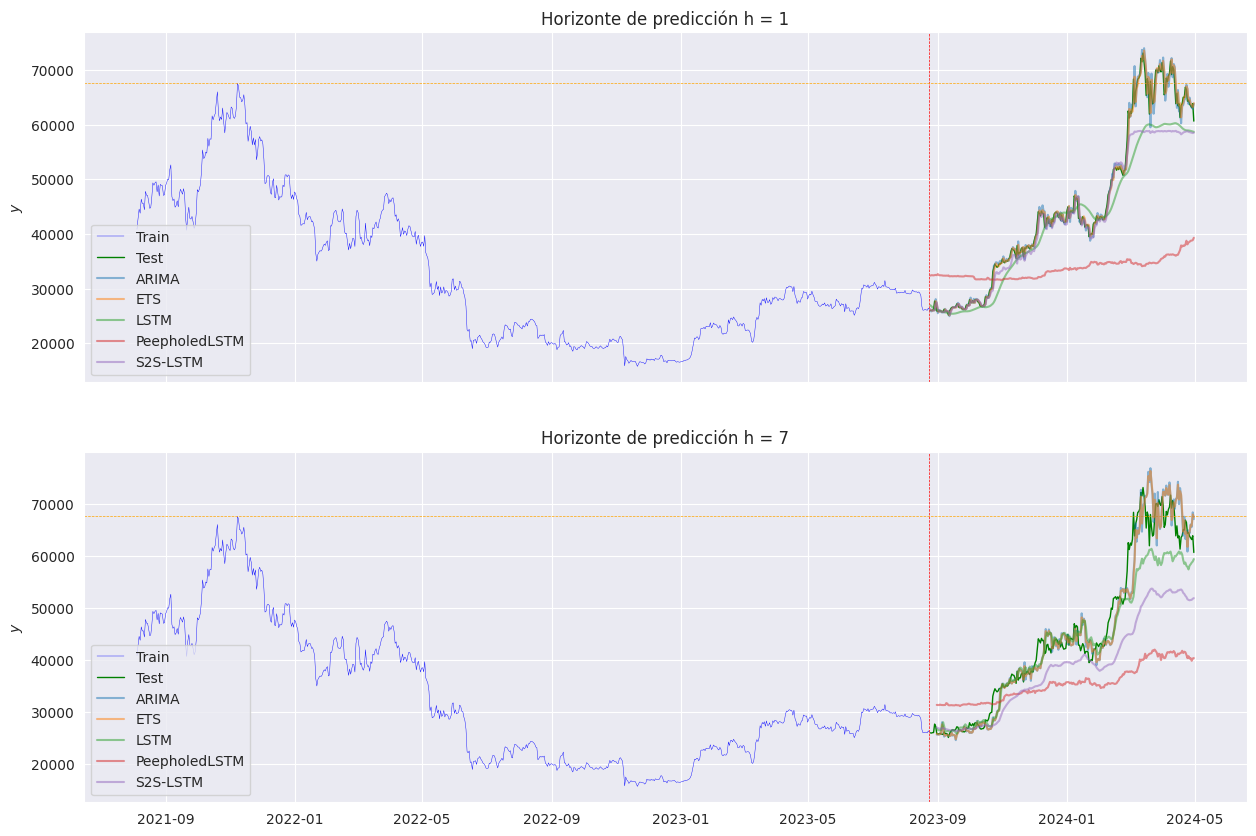

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(y_train.index, y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(y_test.index, y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=y_train.index[split_index-1], color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=y_train.max(), color='orange', linestyle='--', lw=0.5)

    axs[i].plot(y_test.index[h-1:], btc_best_models['btc'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(y_test.index[h-1:], btc_best_models['btc'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(y_test.index[h-1:], scaler_btc.inverse_transform(btc_best_models['btc'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(y_test.index[h-1:], scaler_btc.inverse_transform(btc_best_models['btc'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(y_test.index[h-1:], scaler_btc.inverse_transform(btc_best_models['btc'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='lower left')

    i+=1

plt.show()

### Residuos

Se presentan adicionalmente los errores o residuos de predicción

In [ ]:
def calculate_residuals(y_true, inner_key, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions).reshape(-1)
    return y_true[inner_key-1:] - predictions

residuals = defaultdict(lambda: defaultdict(dict))

for outer_key, dgp in btc_best_models.items():

    for inner_key, h in dgp.items():
        for name, model in h.items():
            residuals[outer_key][inner_key][name] = calculate_residuals(
                y_test, inner_key, model, None if name in ['arima', 'ets'] else scaler_btc
            )

In [ ]:
import matplotlib.ticker

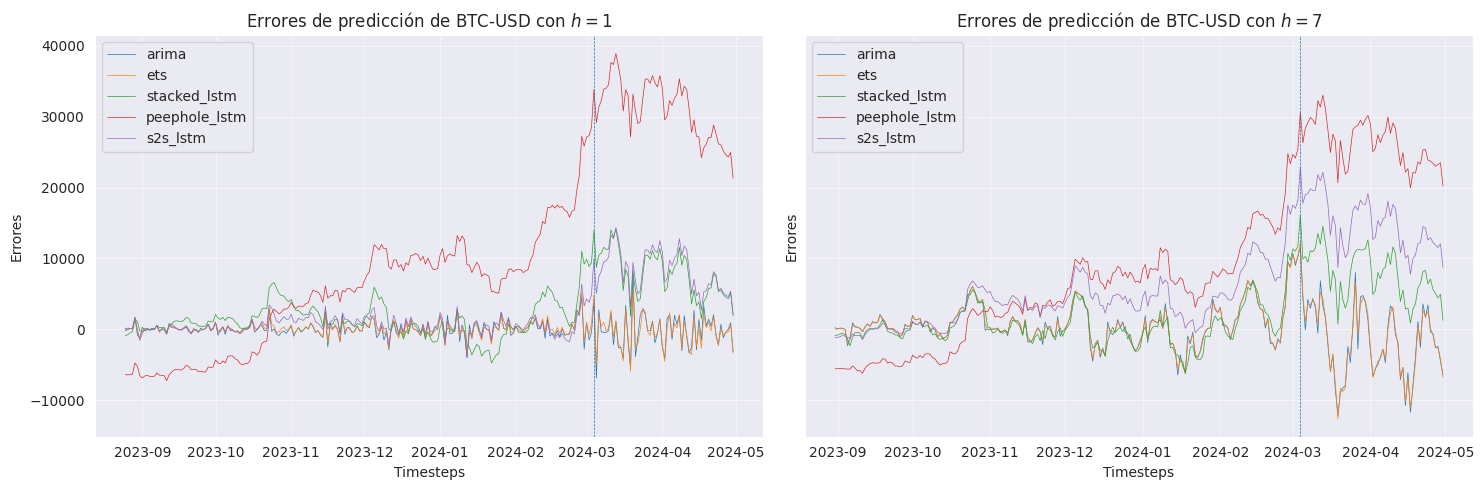

In [ ]:
def plot_residuals_grid(residuals, y_test):
    combinations = [(outer_key, inner_key) for outer_key, inner_dict in residuals.items() for inner_key in inner_dict.keys()]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
    axes = axes.flatten()

    for idx, (ax, (outer_key, inner_key)) in enumerate(zip(axes, combinations)):
        residuals_row = [residuals[outer_key][inner_key][name] for name in residuals[outer_key][inner_key]]

        for name, residual in residuals[outer_key][inner_key].items():
            if idx % 2 == 1:
                ax.plot(y_test.index[6:], residual, label=f'{name}', lw=0.5)
            else:
                ax.plot(residual, label=f'{name}', lw=0.5)

        ax.axvline(x=y_test[y_test>=y_train.max()].index[0], ls='--', lw=0.5)
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Errores')
        ax.set_title(f'Errores de predicción de BTC-USD con $h={inner_key}$')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_residuals_grid(residuals, y_test)

In [ ]:
print("La fecha en la que la serie BTC-USD supera el máximo histórico en el conjunto de test es {}".format(y_test[y_test>=y_train.max()].index[0]))

La fecha en la que la serie BTC-USD supera el máximo histórico en el conjunto de test es 2024-03-04 00:00:00+00:00


### Métricas comparativas

Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_t$ con la última observación disponible $y_{t-1}$
) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplica el test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$
, para cualquier horizonte de pronóstico $h$
.

In [ ]:
h_list = [1,7]
scenarios = ['btc']

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

for p in range(len(h_list)):
  forecast = forecast_evaluation(h=h_list[p],
                                  y_true = y_test.values,
                                  y_pred = np.r_[i[-1], j[:-h_list[p]]])

  naive_forecasting['btc']['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:-h_list[p]]]

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [ ]:
def evaluate_model(h, key2, y_true, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return forecast_evaluation(h=key2, y_true=y_true, y_pred=predictions)

def process_key(dgp, y_true, scaler=None):
    results = defaultdict(dict)
    for key2, h in dgp.items():
        for name, model in h.items():
            results['h_' + f'{key2}'][name] = evaluate_model(h, key2, y_true, model, scaler if name not in ['arima', 'ets'] else None)
    return results

comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in btc_best_models.items():
  y_true = y_test
  scaler = scaler_btc
  comparative_results[key] = process_key(dgp, y_true.values, scaler)

In [ ]:
# Inyectamos en los resultados las métricas de predicción del forecasting näive

for dgp in ['btc']:
  for h in h_list:
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=y_test.values,
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['btc']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_sorted = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_sorted

metric                             MAE      MAPE           MSE         RMSE  \
DGP horizon model                                                             
btc h_1     naive            896.39082   1.82913  1.966112e+06   1402.18108   
            arima           1026.35720   2.09388  2.405581e+06   1550.99353   
            ets              897.17782   1.83234  1.974552e+06   1405.18748   
            stacked_lstm    3374.67155  36.48020  2.303638e+07   4799.62259   
            peephole_lstm  13490.75916  28.14711  2.986747e+08  17282.20855   
            s2s_lstm        2678.26559  36.32848  1.959319e+07   4426.41943   
    h_7     naive           2504.78051   5.13243  1.259222e+07   3548.55119   
            arima           2555.81388   5.24220  1.298807e+07   3603.89688   
            ets             2501.78325   5.13552  1.266926e+07   3559.39108   
            stacked_lstm    3347.96917  35.56948  2.418601e+07   4917.92717   
            peephole_lstm  11549.01937  27.60731  2.209554e+08  14864.56962   
            s2s_lstm        6708.03538  31.82246  8.029581e+07   8960.79282   

metric                        SMAPE  
DGP horizon model                    
btc h_1     naive           1.83563  
            arima           2.09511  
            ets             1.83369  
            stacked_lstm    6.88851  
            peephole_lstm  30.88844  
            s2s_lstm        4.93336  
    h_7     naive           5.27302  
            arima           5.28723  
            ets             5.18324  
            stacked_lstm    6.57869  
            peephole_lstm  25.51933  
            s2s_lstm       13.80328

In [ ]:
df_sorted.to_latex()

'\\begin{tabular}{lllrrrrr}\n\\toprule\n &  & metric & MAE & MAPE & MSE & RMSE & SMAPE \\\\\nDGP & horizon & model &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{12}{*}{btc} & \\multirow[t]{6}{*}{h_1} & naive & 896.390820 & 1.829130 & 1966111.790730 & 1402.181080 & 1.835630 \\\\\n &  & arima & 1026.357200 & 2.093880 & 2405580.937090 & 1550.993530 & 2.095110 \\\\\n &  & ets & 897.177820 & 1.832340 & 1974551.852720 & 1405.187480 & 1.833690 \\\\\n &  & stacked_lstm & 3374.671550 & 36.480200 & 23036376.986350 & 4799.622590 & 6.888510 \\\\\n &  & peephole_lstm & 13490.759160 & 28.147110 & 298674732.495140 & 17282.208550 & 30.888440 \\\\\n &  & s2s_lstm & 2678.265590 & 36.328480 & 19593188.979590 & 4426.419430 & 4.933360 \\\\\n\\cline{2-8}\n & \\multirow[t]{6}{*}{h_7} & naive & 2504.780510 & 5.132430 & 12592215.579130 & 3548.551190 & 5.273020 \\\\\n &  & arima & 2555.813880 & 5.242200 & 12988072.731260 & 3603.896880 & 5.287230 \\\\\n &  & ets & 2501.783250 & 5.135520 & 12669264.839390 & 3559.

#### Diebold-Mariano Test

El test de Diebold-Mariano (1995) permite comparar la precisión de 2 pronósticos. En este caso, se compara la performance para cada DGP y para cada horizonte temporal $h$ del pronóstico näive frente a los demás modelos, tomando en cuenta el error cuadrático de cada serie de pronósticos.

Para ello el test de Diebold-Mariano construye la serie de las diferencias entre los errores cuadráticos de cada modelo, la llamada **loss differential series**, la cual se define como:

$\Delta^{A,B}_{k} = (e^{A}_{k})^2-(e^{B}_{k})^2$

El test de Diebold-Mariano es un test asintótico de tipo z-score sobre el promedio de dicha serie. En este caso, se aplica su versión unilateral cuyas hipótesis son las siguientes:

* $H_0$: la precisión del modelo A (en este caso, el pronóstico näive) es mayor o igual a la del modelo B (modelo alternativo).
* $H_1$: la precisión del modelo A es menor a la del modelo B.

In [ ]:
p_value_dict = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in btc_best_models.items():
    for inner_key, h in dgp.items():
        for name, model in h.items():
          if name in ['arima','ets']:
            p_value = dm_test(V = y_test.values[inner_key-1:].reshape(-1,1),
                    P1 = btc_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                    P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                    one_sided = True)[1][0]
          else:
             p_value = dm_test(V = y_test.values[inner_key-1:].reshape(-1,1),
                      P1 = scaler_btc.inverse_transform(btc_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1)),
                      P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                      one_sided = True)[1][0]

          p_value_dict[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[False])

df_pivot

p_value   arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP h                                                         
btc 1    0.9839  0.5745            1.0       1.0           1.0
    7    0.6955  0.5420            1.0       1.0           1.0

In [ ]:
df_pivot.to_latex()

'\\begin{tabular}{llrrrrr}\n\\toprule\n & p_value & arima & ets & peephole_lstm & s2s_lstm & stacked_lstm \\\\\nDGP & h &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{2}{*}{btc} & 1 & 0.983900 & 0.574500 & 1.000000 & 1.000000 & 1.000000 \\\\\n & 7 & 0.695500 & 0.542000 & 1.000000 & 1.000000 & 1.000000 \\\\\n\\cline{1-7}\n\\bottomrule\n\\end{tabular}\n'

¿Cómo lucirían estas mismas métricas si se restringiese el conjunto de test a las fechas anteriores al 2024-03-04, donde pareciera que empeoran drásticamente las predicciones de las redes neuronales?

In [ ]:
break_point = '2024-03-04'
y_test_reduced = y_test[y_test.index < break_point]
length = len(y_test_reduced)

In [ ]:
h_list = [1,7]
scenarios = ['btc']

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

for p in range(len(h_list)):
  forecast = forecast_evaluation(h=h_list[p],
                                  y_true = y_test_reduced.values,
                                  y_pred = np.r_[i[-1], j[:length-h_list[p]]])

  naive_forecasting['btc']['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:length-h_list[p]]]

In [ ]:
def evaluate_model(h, key2, y_true, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return forecast_evaluation(h=key2, y_true=y_true, y_pred=predictions[:length-key2+1])

def process_key(dgp, y_true, scaler=None):
    results = defaultdict(dict)
    for key2, h in dgp.items():
        for name, model in h.items():
            results['h_' + f'{key2}'][name] = evaluate_model(h, key2, y_true, model, scaler if name not in ['arima', 'ets'] else None)
    return results

comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in btc_best_models.items():
  y_true = y_test_reduced.values
  scaler = scaler_btc
  comparative_results[key] = process_key(dgp, y_true, scaler)

In [ ]:
for dgp in ['btc']:
  for h in h_list:
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=y_test_reduced.values[:length],
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast'][:length-h+1]
      )

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['btc']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_sorted = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_sorted

metric                            MAE      MAPE           MSE        RMSE  \
DGP horizon model                                                           
btc h_1     naive           627.74326   1.57121  9.665582e+05   983.13691   
            arima           708.76558   1.78359  1.068710e+06  1033.78445   
            ets             624.70828   1.56826  9.374065e+05   968.19756   
            stacked_lstm   2022.81717  27.27460  8.216774e+06  2866.49157   
            peephole_lstm  8173.27661  21.78093  9.186474e+07  9584.60939   
            s2s_lstm        971.99383  27.67568  1.933842e+06  1390.62634   
    h_7     naive          2019.41682   4.83552  9.086692e+06  3014.41400   
            arima          1974.53533   4.79318  8.177411e+06  2859.61721   
            ets            1946.22441   4.71395  8.075998e+06  2841.83012   
            stacked_lstm   1937.87384  26.66744  8.510322e+06  2917.24556   
            peephole_lstm  6933.21207  21.34912  7.013151e+07  8374.45565   
            s2s_lstm       4106.51247  23.45196  3.041936e+07  5515.37466   

metric                        SMAPE  
DGP horizon model                    
btc h_1     naive           1.58129  
            arima           1.78752  
            ets             1.57481  
            stacked_lstm    5.23697  
            peephole_lstm  22.00187  
            s2s_lstm        2.45475  
    h_7     naive           5.00984  
            arima           4.89937  
            ets             4.82415  
            stacked_lstm    4.76221  
            peephole_lstm  18.24719  
            s2s_lstm       10.23760

¿Y cómo quedaría el test de Diebold-Mariano para este nuevo conjunto de datos?

In [ ]:
p_value_dict = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in btc_best_models.items():
    for inner_key, h in dgp.items():
        for name, model in h.items():
          if name in ['arima','ets']:
            p_value = dm_test(V = y_test_reduced.values[inner_key-1:].reshape(-1,1),
                    P1 = btc_best_models[outer_key][inner_key][name].predictions['iterative'][:length-inner_key+1].reshape(-1,1),
                    P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'][:length-inner_key+1].reshape(-1,1),
                    one_sided = True)[1][0]
          else:
             p_value = dm_test(V = y_test_reduced.values[inner_key-1:].reshape(-1,1),
                      P1 = scaler_btc.inverse_transform(btc_best_models[outer_key][inner_key][name].predictions['iterative']\
                                                        [:length-inner_key+1].reshape(-1,1)),
                      P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'][:length-inner_key+1].reshape(-1,1),
                      one_sided = True)[1][0]

          p_value_dict[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[False])

df_pivot

p_value   arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP h                                                         
btc 1    0.9179  0.1043            1.0       1.0        1.0000
    7    0.0135  0.0042            1.0       1.0        0.0625

In [ ]:
df_pivot.to_latex()

'\\begin{tabular}{llrrrrr}\n\\toprule\n & p_value & arima & ets & peephole_lstm & s2s_lstm & stacked_lstm \\\\\nDGP & h &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{2}{*}{btc} & 1 & 0.917900 & 0.104300 & 1.000000 & 1.000000 & 1.000000 \\\\\n & 7 & 0.013500 & 0.004200 & 1.000000 & 1.000000 & 0.062500 \\\\\n\\cline{1-7}\n\\bottomrule\n\\end{tabular}\n'